In [1]:
import numpy as np
import os.path

from keras.utils import to_categorical

Using TensorFlow backend.


In [ ]:
# from keras.preprocessing.image import ImageDataGenerator
#data_gen = ImageDataGenerator(samplewise_center=True, rescale=1./255)

# from sklearn.model_selection import train_test_split

In [75]:
DIR = "./"#"/Users/skmohan/Workspace/python/jupyter-notebook/udacity-deeplearning/"

def load_npy(prefix):
    xs = np.load( os.path.join(DIR, "svhn", "{}_preprocessed_img.npy".format(prefix)))
    labels = np.load( os.path.join(DIR, "svhn", "{}_preprocessed_labels.npy".format(prefix)))
    # RGB => Grayscale
    xs = np.dot(xs, [0.299, 0.587, 0.114]).reshape(xs.shape[0], 32, 32, 1)  * 1./255 
    # can this be done by generator?
    xs = np.array([xi - xi.mean() for xi in xs])
    # getting length only for now
    digits_len = to_categorical( np.array(list(map(len, labels)) , dtype=np.int), num_classes=7 )
    padded_labels = np.array(list(map(lambda x: list("{:0>6}".format(x)), labels) ) ).astype(np.int)
    digits = to_categorical(padded_labels).reshape(-1, 6, 10) # 6 digits, 10 classes
    #padded_labels = list(map(lambda x: list("{:0>6}".format(x))[-1], labels) ) 
    #last_digit = to_categorical( padded_labels,num_classes=10)
    ys = [digits_len,] + [ digits[:, i, :] for i in range(6)]
    return xs, ys
    
def load_data():
    x_train, y_train = load_npy("train")
    x_test, y_test = load_npy("test")
    return x_train, y_train, x_test, y_test


In [76]:
x_train, y_train, x_test, y_test = load_data()
# FIXME use Keras Image Data Generator or other ways to augment dataset (shear, rotate etc.)

3 [0, 0, 0, 1, 2, 8]


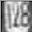

In [4]:
from keras.preprocessing.image import array_to_img
print(np.argmax(y_train[0][8]), [np.argmax(y_train[i+1][8]) for i in range(6)])
array_to_img(x_train[8])

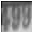

In [5]:
array_to_img(x_test[6424])

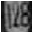

In [83]:
array_to_img(x_train[8] / x_train[8].std())

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense, Reshape, Input, Dot
# X_single, y_single = load_npy("test_single")
from keras.regularizers import l2

regularizer = l2()
img_input = Input(shape=(32,32,1))

cnn = Sequential()
cnn.add(Conv2D(16, (5, 5), padding="same", input_shape=(32, 32, 1), kernel_regularizer=regularizer))
cnn.add(Activation('relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))
#cnn.add(Dropout(0.5))

cnn.add(Conv2D(32, (5, 5),  padding="same", kernel_regularizer=regularizer))
cnn.add(Activation('relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))
#cnn.add(Dropout(0.5))

cnn.add(Conv2D(64, (5, 5), padding="same", kernel_regularizer=regularizer))
cnn.add(Activation('relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.5))

cnn = cnn(img_input)
flat = Flatten()(cnn)

size = Dense(1024, kernel_regularizer=regularizer)(flat)
size = Activation('relu') (size)
size = Dropout(0.5) (size)
size = Dense(7, kernel_regularizer=regularizer)(size)
size_output = Activation('softmax', name="Length_Smax")(size)

size_input = Input(shape=(7,))

digit_inputs = []
digit_outputs = []
digits_merged = []

# FIXME use RNN
for i in range(6):
    digit_output = Dense(10, kernel_regularizer=regularizer)(flat)
    digit_output = Activation('softmax', name="Digit_Last_Smax_{}".format(i))(digit_output)
    digit_input = Input(shape=(10,))
    
    digit_inputs.append(digit_input)
    digit_outputs.append(digit_output)


In [ ]:
# sample = 12942
# y_pred[0][sample][1] *  y_pred[6][sample][9]

# import tensorflow as tf

# inputs = [ y_pred[i][sample:sample+1] for i in range(7) ] + [y_test[i][sample: sample+1] for i in range(7) ]
# input_tensor = [ tf.convert_to_tensor(i, tf.float64) for i in inputs ]

# with tf.Session() as sess:
#     K.set_session(sess)
#     prob = sequence_probability(input_tensor)
#     res = sess.run(prob)

# res

In [7]:
from keras import backend as K

def sequence_probability(inputs):
    #y_pred, y_true = inputs
    len_pred, *digits_pred = inputs[:7]
    len_true, *digits_true = inputs[7:]

    n_digits = 6
    
    pS = K.ones_like( len_true[:, 0] )
    b = K.zeros_like( len_true[:, 0] )
    ones = K.ones_like( len_true[:, 0])
    
    for i in range(n_digits):
        b += len_true[:, - (i+1)]
        ps = K.sum(digits_true[i] * digits_pred[i], axis=1)
        pS = pS * ( ones - b + ps * b )
    ps = K.sum( len_pred * len_true, axis=1)
    pS = pS * ps
    return K.reshape(pS, (-1,1))


In [8]:
from keras.layers import merge

y_pred = [size_output,] + digit_outputs
y_true = [size_input,] + digit_inputs

# FIXME can the merge layer be used to compute loss?
prob_output = merge(y_pred + y_true, mode=sequence_probability, output_shape=(1,), name="Last")
#prob_output = Reshape((1,))(prob_output)

/Users/skmohan/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/skmohan/.virtualenv/tensorflow/lib/python3.5/site-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [9]:
from keras.optimizers import Adam

adam = Adam(decay=0.05)

In [30]:
from keras.models import Model

# use this for training
model = Model(inputs=[img_input, size_input] + digit_inputs, outputs=prob_output)

# use this to predict
estimator = Model(inputs=[img_input], outputs=[size_output,] + digit_outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=['accuracy'])

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 1)     0                                            
____________________________________________________________________________________________________
sequential_1 (Sequential)        (None, 4, 4, 64)      64960                                        
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 1024)          0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1024)          1049600                                      
___________________________________________________________________________________________

In [29]:
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

callbacks = [TensorBoard(log_dir='./logs/logs-20170821-1/'),
             EarlyStopping(patience=5),
             ModelCheckpoint("./best_model_20170821.h5", save_best_only=True)]

In [89]:
model.fit([ x_train, ] + y_train, np.ones(x_train.shape[0]),
          validation_split=0.2, 
          epochs=50,
          batch_size=64,
          initial_epoch=10,
          callbacks=callbacks)

Train on 26721 samples, validate on 6681 samples
Epoch 11/50
26721/26721 [==============================] - 89s - loss: 3.6076 - acc: 0.5849 - val_loss: 3.4192 - val_acc: 0.6316

In [32]:
print("hello.")

hello.


In [170]:
def digit_loss(y_true, y_pred):
    loss = np.ones(y_true[0].shape[0])
    for digit_pred, digit_true in zip(y_pred, y_true):
        loss  = loss *  (digit_pred * digit_true).sum(axis=1)   
    return loss

def accuracy_single(y_true, y_pred):
    len_true = y_true[0]
    digits_true = y_true[1:]
    
    len_pred = y_pred[0]
    digits_pred = y_pred[1:]
    n_samples = len(len_pred)

    n_digits = 6

    pS = np.ones_like( len_true[:, 0] )
    b = np.zeros_like( len_true[:, 0] )
    ones = np.ones_like( len_true[:, 0])
    b_pred = np.zeros_like( len_pred[:, 0] )

    len_pred = np.zeros_like(y_pred[0])
    len_pred[ np.arange(n_samples), y_pred[0].argmax(axis=1) ] = 1

    total_digits = 0
    correct_digits = 0

    for i in range(n_digits):
        b += len_true[:, - (i+1)]
        b_pred += len_pred[:, - (i+1)]
        #print(i, b)
        d_pred = digits_pred[i].argmax(axis=1)
        d_true = digits_true[i].argmax(axis=1)
        correct_digits += ( (d_pred * b_pred)[b >= 1] == d_true[b >= 1]).sum()
        # print(i, correct_digits)
        # print(d_pred * b_pred)
        total_digits += b.sum()
    return correct_digits, int(total_digits)

def accuracy_multi(y_true, y_pred):
    n = y_true[0].shape[0]
    seq_len = np.argmax(y_pred[0], axis=1) #[samples]

    seq_pred = np.sum( [ (seq_len > 6 - i)
                            * np.argmax(y_pred[i], axis=1) 
                            * 10**(6-i) for i in range(1,7) ], 
                axis=0)
    seq_true = np.sum([ np.argmax(y_true[i], axis=1) * 10**(6-i) for i in range(1,7)], axis=0)
    return (seq_pred == seq_true).sum(), n

def performance(y_true, y_pred):
    #loss = digit_loss( y_true[1:], y_pred[1:] )
    #print("Loss : {}".format( np.product(loss))) # XXX Not sure what this means
    correct_digits, total_digits = accuracy_single(y_true, y_pred)
    print("\tAccuracy (single): {:.2%} ({}/{})".format(correct_digits/total_digits, correct_digits, total_digits))
    correct_seq, total_seq = accuracy_multi(y_true, y_pred)
    print("\tAccuracy (seq): {:.2%} ({}/{})".format(correct_seq/total_seq, correct_seq, total_seq))

In [25]:
y_pred = estimator.predict(x_train)
performance(y_train, y_pred)

Accuracy (single): 8.75% (6413/73251)
Accuracy (seq): 0.44% (148/33402)


In [26]:
y_pred = estimator.predict(x_test)
performance(y_test, y_pred)

Accuracy (single): 8.31% (2163/26032)
Accuracy (seq): 0.51% (67/13068)


In [171]:
print("Training..")
y_pred = estimator.predict(x_train)
performance(y_train, y_pred)
print("Test..")
y_pred = estimator.predict(x_test)
performance(y_test, y_pred)

Training..
	Accuracy (single): 90.80% (66519/73257)
	Accuracy (seq): 84.31% (28162/33402)
Test..
	Accuracy (single): 86.15% (22426/26032)
	Accuracy (seq): 77.16% (10083/13068)


In [97]:
print("Training..")
y_pred = estimator.predict(x_train)
performance(y_train, y_pred)
print()
print("Test..")
y_pred = estimator.predict(x_test)
performance(y_test, y_pred)

Training..
Accuracy (single): 91.66% (67144/73251)
Accuracy (seq): 84.31% (28162/33402)
Test..
Accuracy (single): 86.84% (22607/26032)
Accuracy (seq): 77.16% (10083/13068)


In [101]:
import csv

def write2csv(y_pred, y_true, filepath):
    assert y_pred[0].shape == y_true[0].shape
    n = y_true[0].shape[0]
    seq_len = np.argmax(y_pred[0], axis=1) #[samples]

    seq_pred = np.sum( [ (seq_len > 6 - i)
                            * np.argmax(y_pred[i], axis=1) 
                            * 10**(6-i) for i in range(1,7) ], 
                axis=0)
    seq_true = np.sum([ np.argmax(y_true[i], axis=1) * 10**(6-i) for i in range(1,7)], axis=0)

    with open(filepath, "w") as fp:
        writer = csv.writer(fp)
        writer.writerow(["digits_actual", "digits_predicted", "len_predicted"])
        writer.writerows(zip(seq_true,  seq_pred, seq_len))

write2csv(y_pred, y_test, "./test.csv")

In [ ]:
y_pred = estimator.predict(x_test)
performance(y_test, y_pred)

In [ ]:
y_pred = estimator.predict(x_test)
performance(y_test, y_pred)

In [13]:
#samples = [ 3373, 2260, 3371, 7716, 6664, 10507, 8507] 
from IPython.display import display
from keras.preprocessing.image import array_to_img

def review(X_true, y_true, nsamples=5, samples=None):
    if samples is  None:
        samples = np.random.choice(X_true.shape[0], nsamples)

    print("Samples: ", samples)
    y_pred = estimator.predict(X_true[samples])
    y_true_ = [ y_true[i][samples] for i in range(7) ]

    performance( y_true_, y_pred)

    for s,sample in enumerate(samples):
        size_pred = np.argmax( y_pred[0][s] )
        num_pred = "".join(map(str, [np.argmax(y_pred[i+1][s]) for i in range(6 - size_pred, 6)] ))

        size_true = np.argmax( y_true[0][sample] )
        num_true = "".join(map(str, [np.argmax(y_true_[i+1][s]) for i in range(6 - size_true, 6)] ))
        probability = np.product( [ (y_pred[i+1][s] * y_true[i+1][s]).sum() for i in range(6-size_true, 6) ] )
        
        print( "Predicted {:>6} ({}) {}".format(num_pred, size_pred, "✓" if num_pred == num_true else "✗"))
        print( "Actual    {:>6} ({})".format(num_true, size_true))
        print( "Probability: {}".format(probability))
        # print( num_pred == num_true )
        display(array_to_img(X_true[sample]))


Samples:  [4813, 10778, 5441, 924, 1522]
Accuracy (single): 100.00% (8/8)
Accuracy (seq): 100.00% (5/5)
Predicted     15 (2) ✓
Actual        15 (2)
Probability: 0.04826527040710715


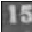

Predicted      2 (1) ✓
Actual         2 (1)
Probability: 2.335226734206941e-10


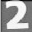

Predicted      7 (1) ✓
Actual         7 (1)
Probability: 4.3117637460454716e-08


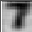

Predicted     85 (2) ✓
Actual        85 (2)
Probability: 3.2910304847057466e-12


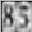

Predicted     14 (2) ✓
Actual        14 (2)
Probability: 1.6109758594516567e-06


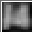

In [35]:
review(x_test, y_test, samples=[4813, 10778, 5441, 924, 1522])

Samples:  [7386, 12942, 9240, 9134, 11244, 7677, 13046, 11032, 6436, 6424]
Accuracy (single): 85.00% (17/20)
Accuracy (seq): 80.00% (8/10)
Predicted     15 (2) ✓
Actual        15 (2)
Probability: 1.998127695460722e-06


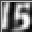

Predicted      9 (1) ✓
Actual         9 (1)
Probability: 0.006624949164688587


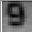

Predicted     22 (2) ✓
Actual        22 (2)
Probability: 4.445860010265099e-08


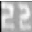

Predicted     34 (2) ✗
Actual        37 (2)
Probability: 0.0004732919446205179


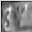

Predicted     44 (2) ✓
Actual        44 (2)
Probability: 2.0918788592484287e-06


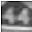

Predicted     77 (2) ✗
Actual        22 (2)
Probability: 6.512015884660719e-09


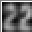

Predicted     26 (2) ✓
Actual        26 (2)
Probability: 2.1958471970452376e-09


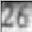

Predicted     15 (2) ✓
Actual        15 (2)
Probability: 0.029444130757403264


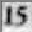

Predicted     27 (2) ✓
Actual        27 (2)
Probability: 3.0788119964178994e-21


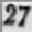

Predicted    499 (3) ✓
Actual       499 (3)
Probability: 2.273316037384226e-05


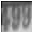

In [34]:
review(x_test, y_test, samples=[ 7386, 12942,  9240,  9134, 11244, 7677, 13046, 11032,  6436,  6424])

Samples:  [7386, 12942, 9240, 9134, 11244, 7677, 13046, 11032, 6436, 6424]
Accuracy (single): 85.00% (17/20)
Accuracy (seq): 70.00% (7/10)
Predicted     16 (2) ✗
Actual        15 (2)
Probability: 2.6964179832014725e-07


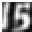

Predicted      9 (1) ✓
Actual         9 (1)
Probability: 0.044507864862680435


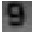

Predicted     22 (2) ✓
Actual        22 (2)
Probability: 3.751216178981588e-06


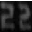

Predicted     37 (2) ✓
Actual        37 (2)
Probability: 9.333307466045896e-07


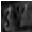

Predicted      2 (1) ✗
Actual        44 (2)
Probability: 4.329178518563598e-07


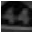

Predicted     22 (2) ✓
Actual        22 (2)
Probability: 2.9618481107485403e-10


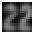

Predicted     26 (2) ✓
Actual        26 (2)
Probability: 3.228989960421524e-10


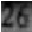

Predicted     15 (2) ✓
Actual        15 (2)
Probability: 0.0014993090298995454


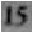

Predicted     27 (2) ✓
Actual        27 (2)
Probability: 1.8727505072486472e-18


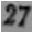

Predicted    399 (3) ✗
Actual       499 (3)
Probability: 2.670348472495877e-11


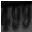

In [88]:
review(x_test, y_test, samples=[ 7386, 12942,  9240,  9134, 11244, 7677, 13046, 11032,  6436,  6424])

Samples:  [  28  429  150  308 1900]
Accuracy (single): 66.67% (10/15)
Accuracy (seq): 20.00% (1/5)
Predicted    117 (3) ✗
Actual       212 (3)
Probability: 4.262422706655044e-05


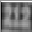

Predicted    164 (3) ✗
Actual       161 (3)
Probability: 6.929425525396185e-05


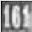

Predicted    215 (3) ✓
Actual       215 (3)
Probability: 1.2216414986754134e-21


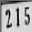

Predicted    167 (3) ✗
Actual       267 (3)
Probability: 5.106909434417735e-07


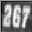

Predicted    215 (3) ✗
Actual       216 (3)
Probability: 1.2494710235417948e-07


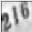

In [46]:
len_test = y_test[0].argmax(axis=1)
review(x_test[ len_test == 3 ], [ yi[len_test==3] for yi in y_test ] )

146
Samples:  [ 51 107  28  24   4]
Accuracy (single): 70.00% (14/20)
Accuracy (seq): 40.00% (2/5)
Predicted   1085 (4) ✗
Actual      6185 (4)
Probability: 1.2154063072478384e-46


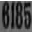

Predicted   1119 (4) ✗
Actual      1779 (4)
Probability: 4.1396850361733873e-23


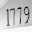

Predicted   1934 (4) ✓
Actual      1934 (4)
Probability: 1.3282140984796668e-40


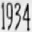

Predicted   2440 (4) ✓
Actual      2440 (4)
Probability: 1.5008156783946828e-32


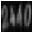

Predicted    205 (3) ✗
Actual      2409 (4)
Probability: 3.324816658886622e-08


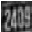

In [95]:
len_test = y_test[0].argmax(axis=1)
print(len_test[len_test==4].shape[0])
review(x_test[ len_test == 4 ], [ yi[len_test==4] for yi in y_test ] )

Samples:  [7386, 12942, 9240, 9134, 11244, 7677, 13046, 11032, 6436, 6424]
Accuracy (single): 90.00% (18/20.0)
Accuracy (seq): 80.00% (8/10)
Predicted     15 (2) ✓
Actual        15 (2)
Probability: 1.024384963282303e-08


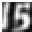

Predicted      9 (1) ✓
Actual         9 (1)
Probability: 0.0001964652765309438


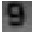

Predicted     22 (2) ✓
Actual        22 (2)
Probability: 3.2542782746656663e-08


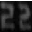

Predicted     32 (2) ✗
Actual        37 (2)
Probability: 8.186067566933906e-06


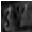

Predicted     42 (2) ✗
Actual        44 (2)
Probability: 4.069369796714454e-06


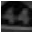

Predicted     22 (2) ✓
Actual        22 (2)
Probability: 1.5233278542826773e-09


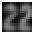

Predicted     26 (2) ✓
Actual        26 (2)
Probability: 3.65234903328843e-13


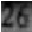

Predicted     15 (2) ✓
Actual        15 (2)
Probability: 5.9177303581059264e-05


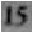

Predicted     27 (2) ✓
Actual        27 (2)
Probability: 7.987346767518083e-25


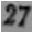

Predicted    499 (3) ✓
Actual       499 (3)
Probability: 6.3390839054474e-16


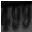

In [168]:
review(x_test, y_test, samples=[ 7386, 12942,  9240,  9134, 11244, 7677, 13046, 11032,  6436,  6424])

Samples:  [20]
Accuracy (single): 0.00% (0/3.0)
Accuracy (seq): 0.00% (0/1)
Predicted      6 (1) ✗
Actual       129 (3)
Probability: 2.007470480083559e-09


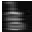

In [167]:
review(x_test, y_test, samples=[20,])#[20, 67, 6877, 9514])

In [ ]:
estimator.save("./svhn/model_20170820.h5")

In [ ]:
size = np.argmax( y_pred[0][2] )
num_pred = "".join(map(str, [np.argmax(y_pred[i+1][2]) for i in range(0, 6)] ))
size, num_pred

In [ ]:
import pandas as pd

In [ ]:
pd.DataFrame({"digit_{}".format(i): y_pred[i][2] for i in range(1, 7)})

In [ ]:
from keras.models import load_model

registered_models = ["./svhn/model_20170807.h5", "./svhn/model_20170810.h5", "./svhn/model_20170813.h5"]

for version in registered_models:
    print("="*5 + " " + version + " " + "="*5)
    modelv = load_model(version)
    y_pred_v = modelv.predict(x_test)
    performance(y_test, y_pred_v)

In [161]:
samples = [20, 9514, 1046, 11766, 11194]

y_true = [ yi[samples] for yi in y_test ]
y_pred = estimator.predict(x_test[samples])

In [162]:
[ yi.argmax(axis=1) for yi in y_true ]

[array([3, 2, 3, 2, 3]),
 array([0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0]),
 array([1, 0, 1, 0, 7]),
 array([2, 1, 2, 5, 5]),
 array([9, 5, 1, 2, 4])]

In [163]:
[ yi.argmax(axis=1) for yi in y_pred ]

[array([1, 1, 3, 2, 3]),
 array([0, 0, 0, 0, 0]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 2, 1, 5, 1]),
 array([1, 5, 3, 9, 5]),
 array([6, 5, 1, 2, 4])]

In [116]:
accuracy_single(y_true, y_pred)

(3, 5)

In [165]:
def accuracy_single(y_true, y_pred):
    len_true = y_true[0]
    digits_true = y_true[1:]
    
    len_pred = y_pred[0]
    digits_pred = y_pred[1:]
    n_samples = len(len_pred)

    n_digits = 6

    pS = np.ones_like( len_true[:, 0] )
    b = np.zeros_like( len_true[:, 0] )
    ones = np.ones_like( len_true[:, 0])
    b_pred = np.zeros_like( len_pred[:, 0] )

    len_pred = np.zeros_like(y_pred[0])
    len_pred[ np.arange(n_samples), y_pred[0].argmax(axis=1) ] = 1

    total_digits = 0
    correct_digits = 0

    for i in range(n_digits):
        b += len_true[:, - (i+1)]
        b_pred += len_pred[:, - (i+1)]
        #print(i, b)
        d_pred = digits_pred[i].argmax(axis=1)
        d_true = digits_true[i].argmax(axis=1)
        correct_digits += ( (d_pred * b_pred)[b >= 1] == d_true[b >= 1]).sum()
        # print(i, correct_digits)
        # print(d_pred * b_pred)
        total_digits += b.sum()
    return correct_digits, total_digits


In [166]:
accuracy_single(y_true, y_pred)

(6, 13.0)

In [151]:
b_pred = np.zeros_like(y_pred[0])
y_pred[0].argmax(axis=1).ravel()
b_pred[ np.arange(3), y_pred[0].argmax(axis=1) ] = 1
b_pred

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.]], dtype=float32)